<a href="https://colab.research.google.com/github/Vaishali9522/NeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(7)
%matplotlib inline

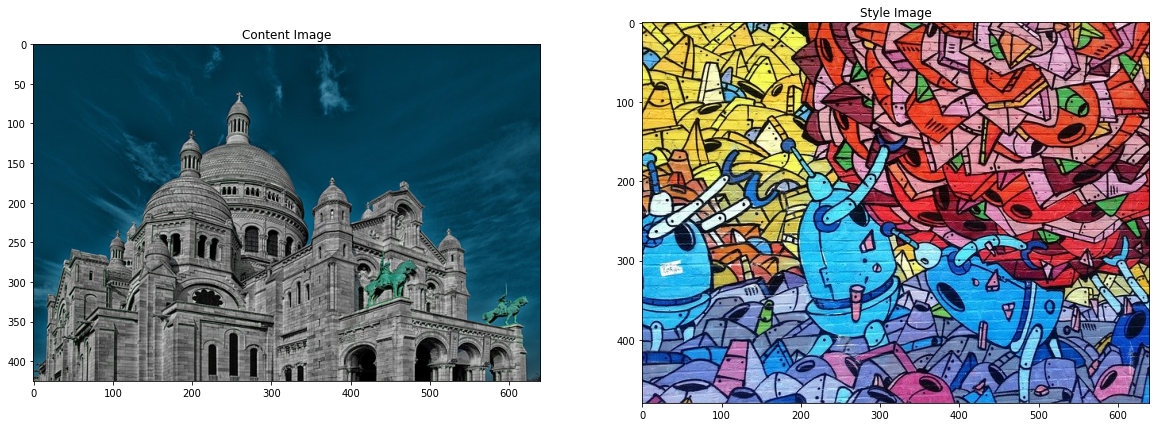

In [20]:
content_img = plt.imread('/content/drive/My Drive/sacre-coeur-102110_640.jpg')
style_img = plt.imread('/content/drive/My Drive/graffiti-569265_640.jpg')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(content_img)
ax1.set_title('Content Image')
ax2.imshow(style_img)
ax2.set_title('Style Image')
plt.show()

In [0]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400,400])
  img = tf.expand_dims(img, 0)
  # img = img[tf.newaxis, :]     # Shape -> (batch_size, h, w, d)
  return img

In [0]:
content = load_image('/content/drive/My Drive/sacre-coeur-102110_640.jpg')
style = load_image('/content/drive/My Drive/graffiti-569265_640.jpg')

In [23]:
print(content.shape)
print(style.shape)

(1, 400, 400, 3)
(1, 400, 400, 3)


In [0]:
vgg = tf.keras.applications.VGG19(include_top=False)
vgg.trainable = False

In [25]:
for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [26]:
content_layers = ['block4_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print(num_content_layers)
print(num_style_layers)

1
5


In [0]:
def mini_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model

In [0]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(fun, fun, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [0]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg = mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_inputs = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]    # Calculate the gram matrix for each layer

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}



In [0]:
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [0]:
# Custom weights for style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [0]:
def total_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [0]:
target_image = tf.Variable(content)

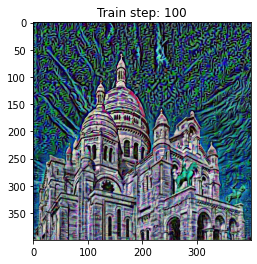

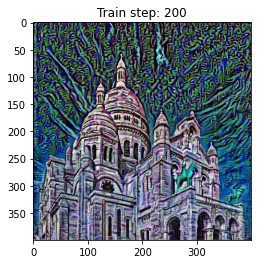

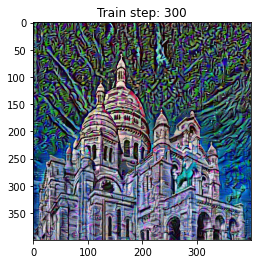

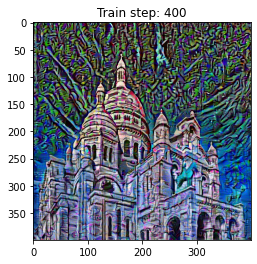

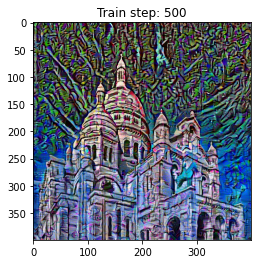

In [36]:
epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()